In [1]:
pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 989.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
   

In [2]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 5
warnings.simplefilter("ignore")
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Dataset_IC01/Gigi Tampak Atas '

def load_data_from_directory(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                if os.path.isfile(image_path):
                    image_paths.append(image_path)
                    labels.append(label)

    df = pd.DataFrame({
        'Image Path': image_paths,
        'Label': labels
    })

    return df

def train_val_test_split(X, y, train_size, val_size, test_size):
    """
    Splits the data into train, validation, and test sets.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size)
    val_test_split = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=val_test_split)

    train_df = pd.DataFrame({'Image Path': X_train, 'Label': y_train})
    val_df = pd.DataFrame({'Image Path': X_val, 'Label': y_val})
    test_df = pd.DataFrame({'Image Path': X_test, 'Label': y_test})

    return train_df, val_df, test_df


df = load_data_from_directory(data_dir)

train_df, val_df, test_df = train_val_test_split(df['Image Path'], df['Label'], train_size=0.8, val_size=0.1, test_size=0.1)

print(f"Train df ({train_df.shape}), val df ({val_df.shape}), test df ({test_df.shape})")

Train df ((2898, 2)), val df ((362, 2)), test df ((363, 2))


In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)

train_gen = train_datagen.flow_from_dataframe(train_df, batch_size=10,shuffle=True,directory='Train', x_col='Image Path',y_col='Label', target_size=(224,224),class_mode='categorical')

valid_datagen = ImageDataGenerator()

valid_gen = valid_datagen.flow_from_dataframe(val_df, batch_size=10,shuffle=True,directory='Train', x_col='Image Path', y_col='Label',target_size=(224,224), class_mode='categorical')

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
test_gen=valid_datagen.flow_from_dataframe(test_df, directory='Train', x_col='Image Path', y_col='Label', target_size=(224,224),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 2898 validated image filenames belonging to 5 classes.
Found 362 validated image filenames belonging to 5 classes.
Found 363 validated image filenames belonging to 5 classes.


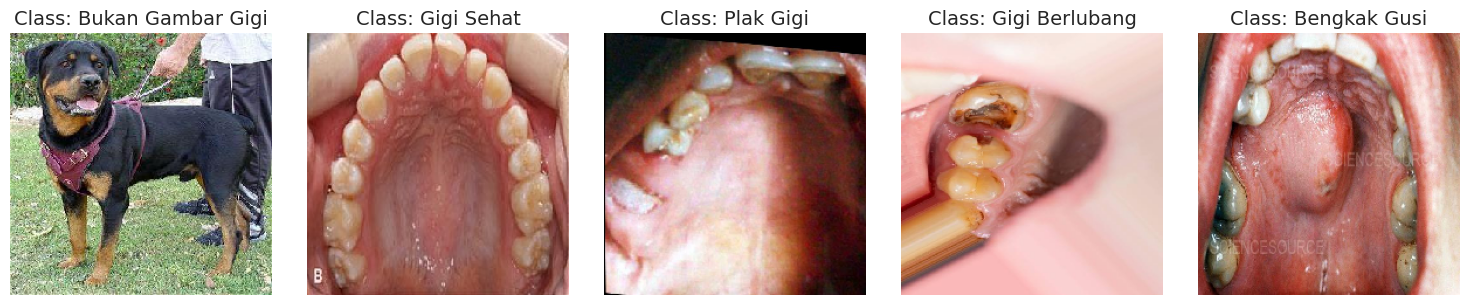

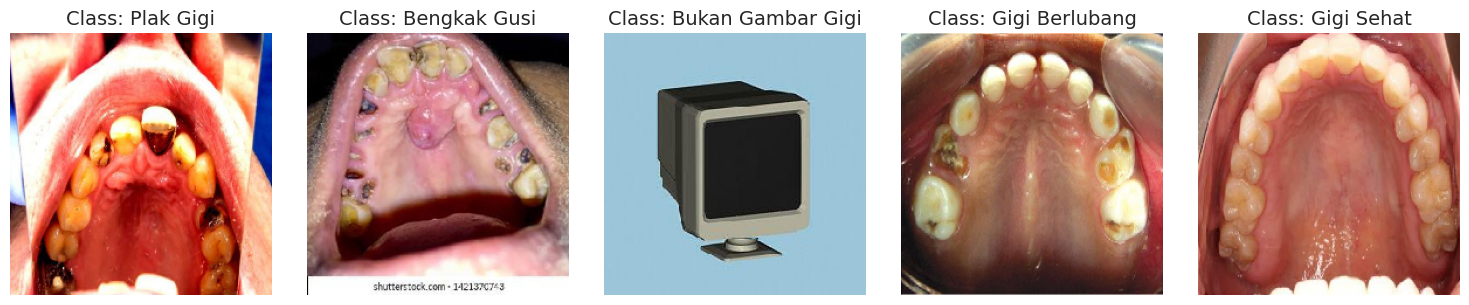

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

def show_random_samples(dataframe, directory, x_col, y_col, target_size=(224,224), n_samples=1):
    unique_classes = dataframe[y_col].unique()
    fig, axes = plt.subplots(n_samples, len(unique_classes), figsize=(len(unique_classes) * 3, n_samples * 3))

    for i, label in enumerate(unique_classes):
        samples = dataframe[dataframe[y_col] == label].sample(n_samples)
        for j, idx in enumerate(samples.index):
            img_path = os.path.join(directory, samples.loc[idx, x_col])
            img = load_img(img_path, target_size=target_size)
            ax = axes[j, i] if n_samples > 1 else axes[i]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(f"Class: {label}", fontsize=14)

    plt.tight_layout()
    plt.show()

# Show random samples from the training set
show_random_samples(train_df, 'Train', 'Image Path', 'Label', n_samples=1)

# Show random samples from the validation set
show_random_samples(val_df, 'Train', 'Image Path', 'Label', n_samples=1)

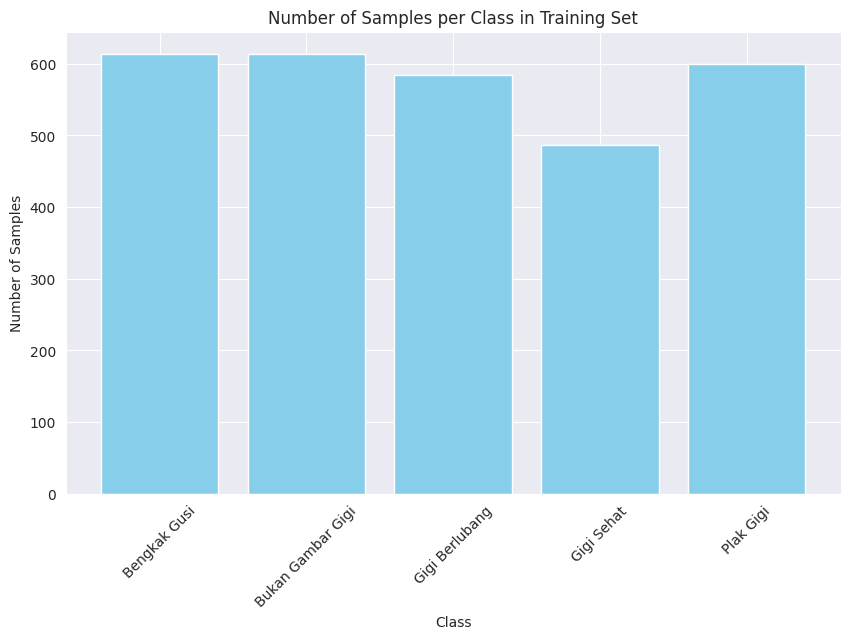

In [ ]:
class_counts = Counter(train_gen.classes)
class_labels = list(train_gen.class_indices.keys())
sorted_class_counts = [class_counts[i] for i in range(len(class_labels))]

plt.figure(figsize=(10, 6))
plt.bar(class_labels, sorted_class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class in Training Set')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs['accuracy'] > 0.99 and logs['val_accuracy'] > 0.99:
                print("\nReached 99% training accuracy and 99% validation accuracy, so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [ ]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max')
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.001),
          bias_regularizer=regularizers.l1(0.001), activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(128, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.001),
          bias_regularizer=regularizers.l1(0.001), activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(5, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("best_model_acc.weights.h5", monitor='accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

history=model.fit(x=train_gen,  epochs=100, verbose=1,  validation_data=valid_gen, callbacks=[callbacks, checkpoint])

Epoch 1/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6050 - loss: 17.9177
Epoch 1: accuracy improved from -inf to 0.67564, saving model to best_model_acc.weights.h5
290/290 ━━━━━━━━━━━━━━━━━━━━ 2098s 7s/step - accuracy: 0.6052 - loss: 17.9084 - val_accuracy: 0.7403 - val_loss: 11.9069
Epoch 2/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7995 - loss: 10.4026
Epoch 2: accuracy improved from 0.67564 to 0.82195, saving model to best_model_acc.weights.h5
290/290 ━━━━━━━━━━━━━━━━━━━━ 63s 213ms/step - accuracy: 0.7995 - loss: 10.3996 - val_accuracy: 0.8232 - val_loss: 7.9844
Epoch 3/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8751 - loss: 7.2827
Epoch 3: accuracy improved from 0.82195 to 0.87474, saving model to best_model_acc.weights.h5
290/290 ━━━━━━━━━━━━━━━━━━━━ 63s 214ms/step - accuracy: 0.8751 - loss: 7.2808 - val_accuracy: 0.8702 - val_loss: 5.5931
Epoch 4/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8989 - loss: 5.1103
Epoc

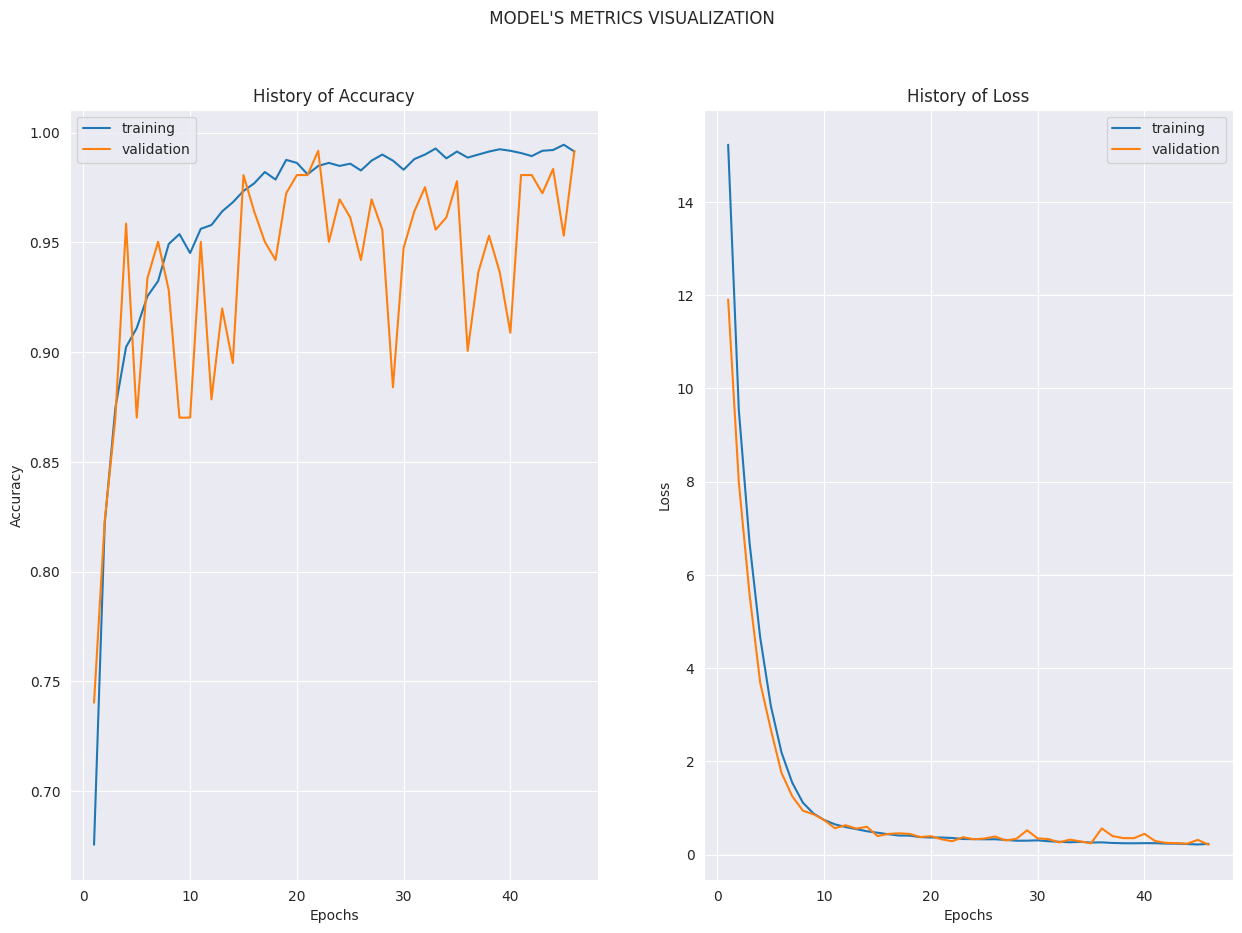

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [ ]:
predictions = model.predict(test_gen)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = test_gen.classes

print(classification_report(true_labels, predicted_labels))

11/11 ━━━━━━━━━━━━━━━━━━━━ 182s 17s/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        76
           1       0.99      1.00      0.99        80
           2       0.99      1.00      0.99        74
           3       1.00      0.95      0.98        64
           4       1.00      1.00      1.00        69

    accuracy                           0.99       363
   macro avg       0.99      0.99      0.99       363
weighted avg       0.99      0.99      0.99       363



In [ ]:
# Menyimpan model dalam format .keras
model.save('EfficientNet_TampakAtas.h5')

In [ ]:
import os

# Menentukan path tujuan untuk menyimpan model
target_dir = '/content/drive/MyDrive/'

# Membuat direktori tujuan jika belum ada
os.makedirs(target_dir, exist_ok=True)

# Menyimpan model dengan path lengkap
model_path = os.path.join(target_dir, 'EfficientNet_TampakAtas.h5')
model.save(model_path)

In [ ]:
import keras.saving

# Menyimpan model dalam format .keras
keras.saving.save_model(model, 'EfficientNet_TampakAtas.keras')

In [ ]:
import os

# Menentukan path tujuan untuk menyimpan model
target_dir = '/content/drive/MyDrive/'

# Membuat direktori tujuan jika belum ada
os.makedirs(target_dir, exist_ok=True)

# Menyimpan model dengan path lengkap
model_path = os.path.join(target_dir, 'EfficientNet_TampakAtas.keras')
model.save(model_path)

Model :

```
https://drive.google.com/file/d/1LUFnqHsiLkySt5YcHKLb1hlrHqCFSPM2/view?usp=sharing
```


Data Uji:

```
https://drive.google.com/drive/folders/14NLtdO53huvXtdaBvRUceQoBw5kpIGBW?usp=sharing
```

**Run the TensorFlow.js Converter on The Saved Keras Model**

In [4]:
import tensorflowjs as tfjs
print(tfjs.__version__)
print(tf.__version__)

4.19.0
2.16.1


In [13]:
# YOUR CODE HERE
import tensorflowjs as tfjs

!tensorflowjs_converter --input_format keras \
                       /content/drive/MyDrive/EfficientNet_TampakAtas.h5 \
                       /content/Model_TFJS

2024-05-30 06:49:41.481685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file
weight normalization/count with shape () and dtype int64 was auto converted to the type int32


In [14]:
import shutil

# Path to the folder you want to zip
folder_path = './Model_TFJS'
output_path = './drive/MyDrive/Model_TFJS'

# Create a ZIP file with the same name as the folder
zip_file = shutil.make_archive(output_path, 'zip', folder_path)

print(f'ZIP file created: {zip_file}')

ZIP file created: /content/drive/MyDrive/Model_TFJS.zip


**Model Bentuk (pb)**

In [ ]:
import tensorflow as tf

# Load your Keras model
model = tf.keras.models.load_model('/content/EfficientNet_TampakAtas.h5')

# Convert and save the model to TensorFlow.js format
path = ('/content/Model_PB')
tf.saved_model.save(model,path)

In [ ]:
import shutil

# Path to the folder you want to zip
folder_path = './Model_PB'
output_path = './drive/MyDrive/Model_PB'

# Create a ZIP file with the same name as the folder
zip_file = shutil.make_archive(output_path, 'zip', folder_path)

print(f'ZIP file created: {zip_file}')

ZIP file created: /content/drive/MyDrive/Model_PB.zip


**Tes Model**

In [ ]:
from tensorflow.keras.models import load_model

# Ensure the model is loaded

model = load_model('/content/EfficientNet_TampakAtas.h5')

# Test data directory
test_data_dir = '/content/drive/MyDrive/test'  # Replace with your actual test data path

In [ ]:
# Load and preprocess test data
def load_test_data(directory):
    image_paths = []
    for image_file in os.listdir(directory):
        image_path = os.path.join(directory, image_file)
        if os.path.isfile(image_path):
            image_paths.append(image_path)
    return image_paths

test_image_paths = load_test_data(test_data_dir)

# Function to preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Measure prediction time
start_time = time.time()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted class for /content/drive/MyDrive/test/gigi2.jpg: Bukan Gambar Gigi
Class probability: 1.00


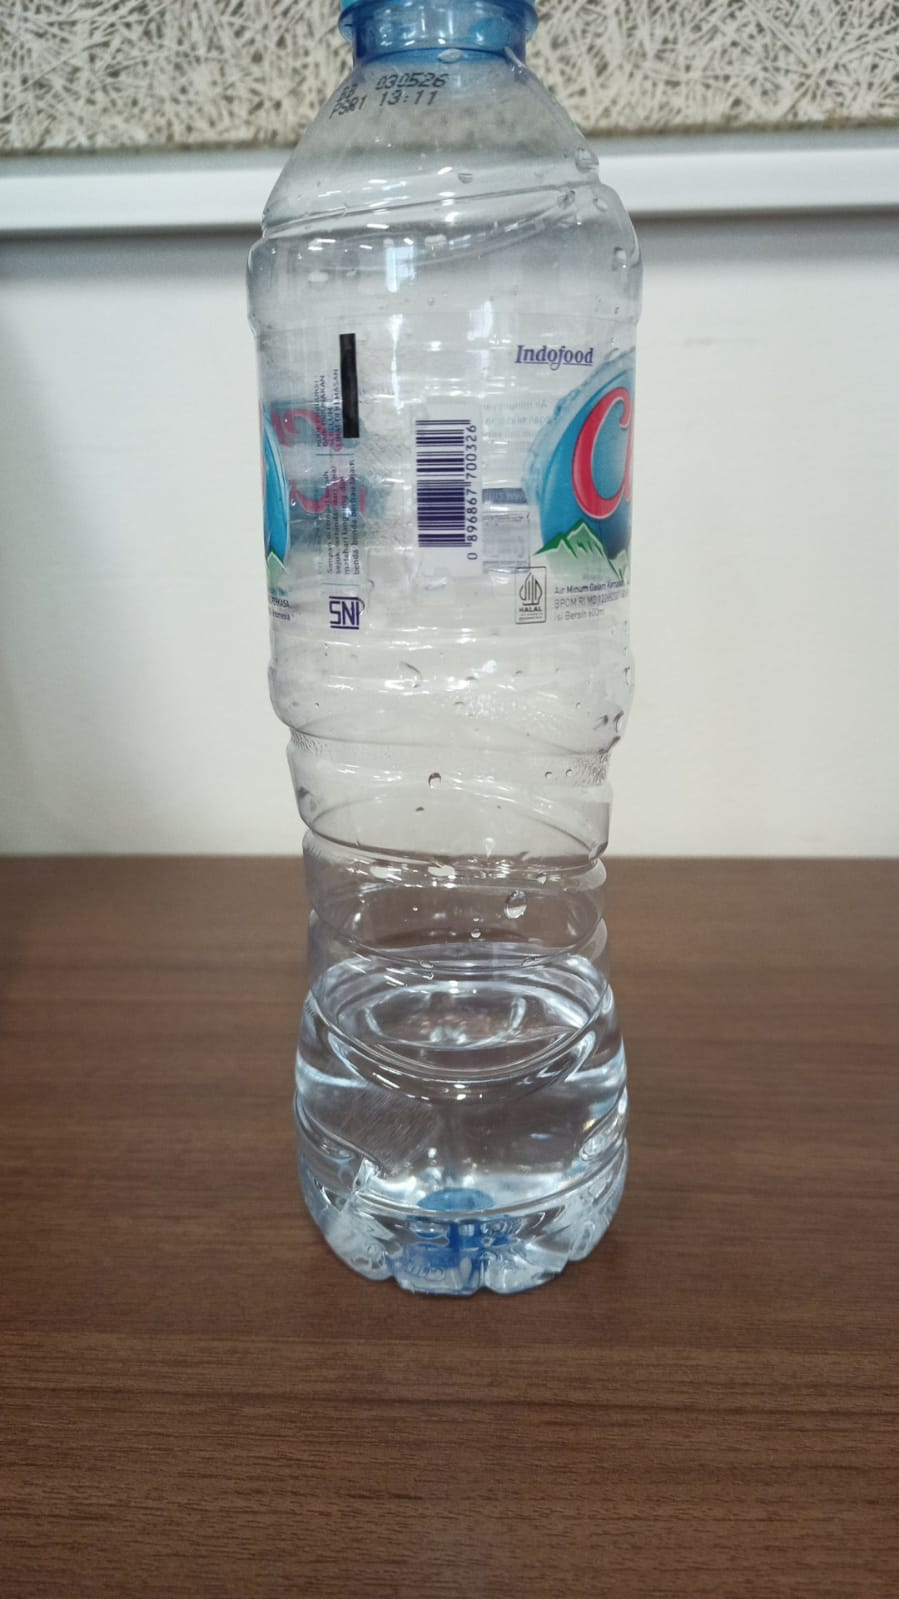


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class for /content/drive/MyDrive/test/gigi4.jpeg: Plak Gigi
Class probability: 0.96


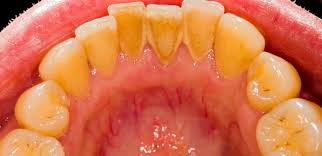


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class for /content/drive/MyDrive/test/gigi5.jpg: Gigi Berlubang
Class probability: 0.78


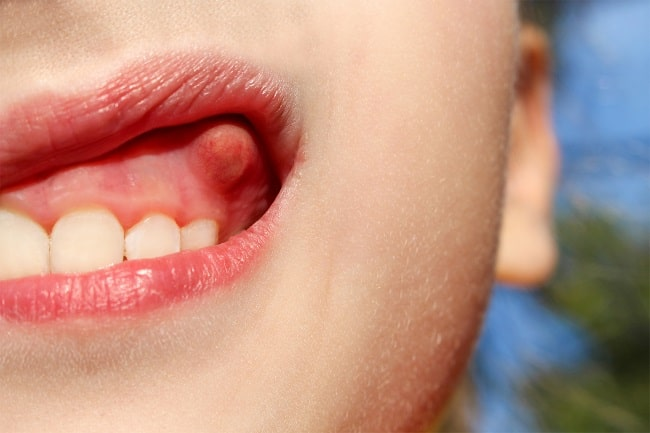


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class for /content/drive/MyDrive/test/gigi1.jpg: Gigi Berlubang
Class probability: 0.49


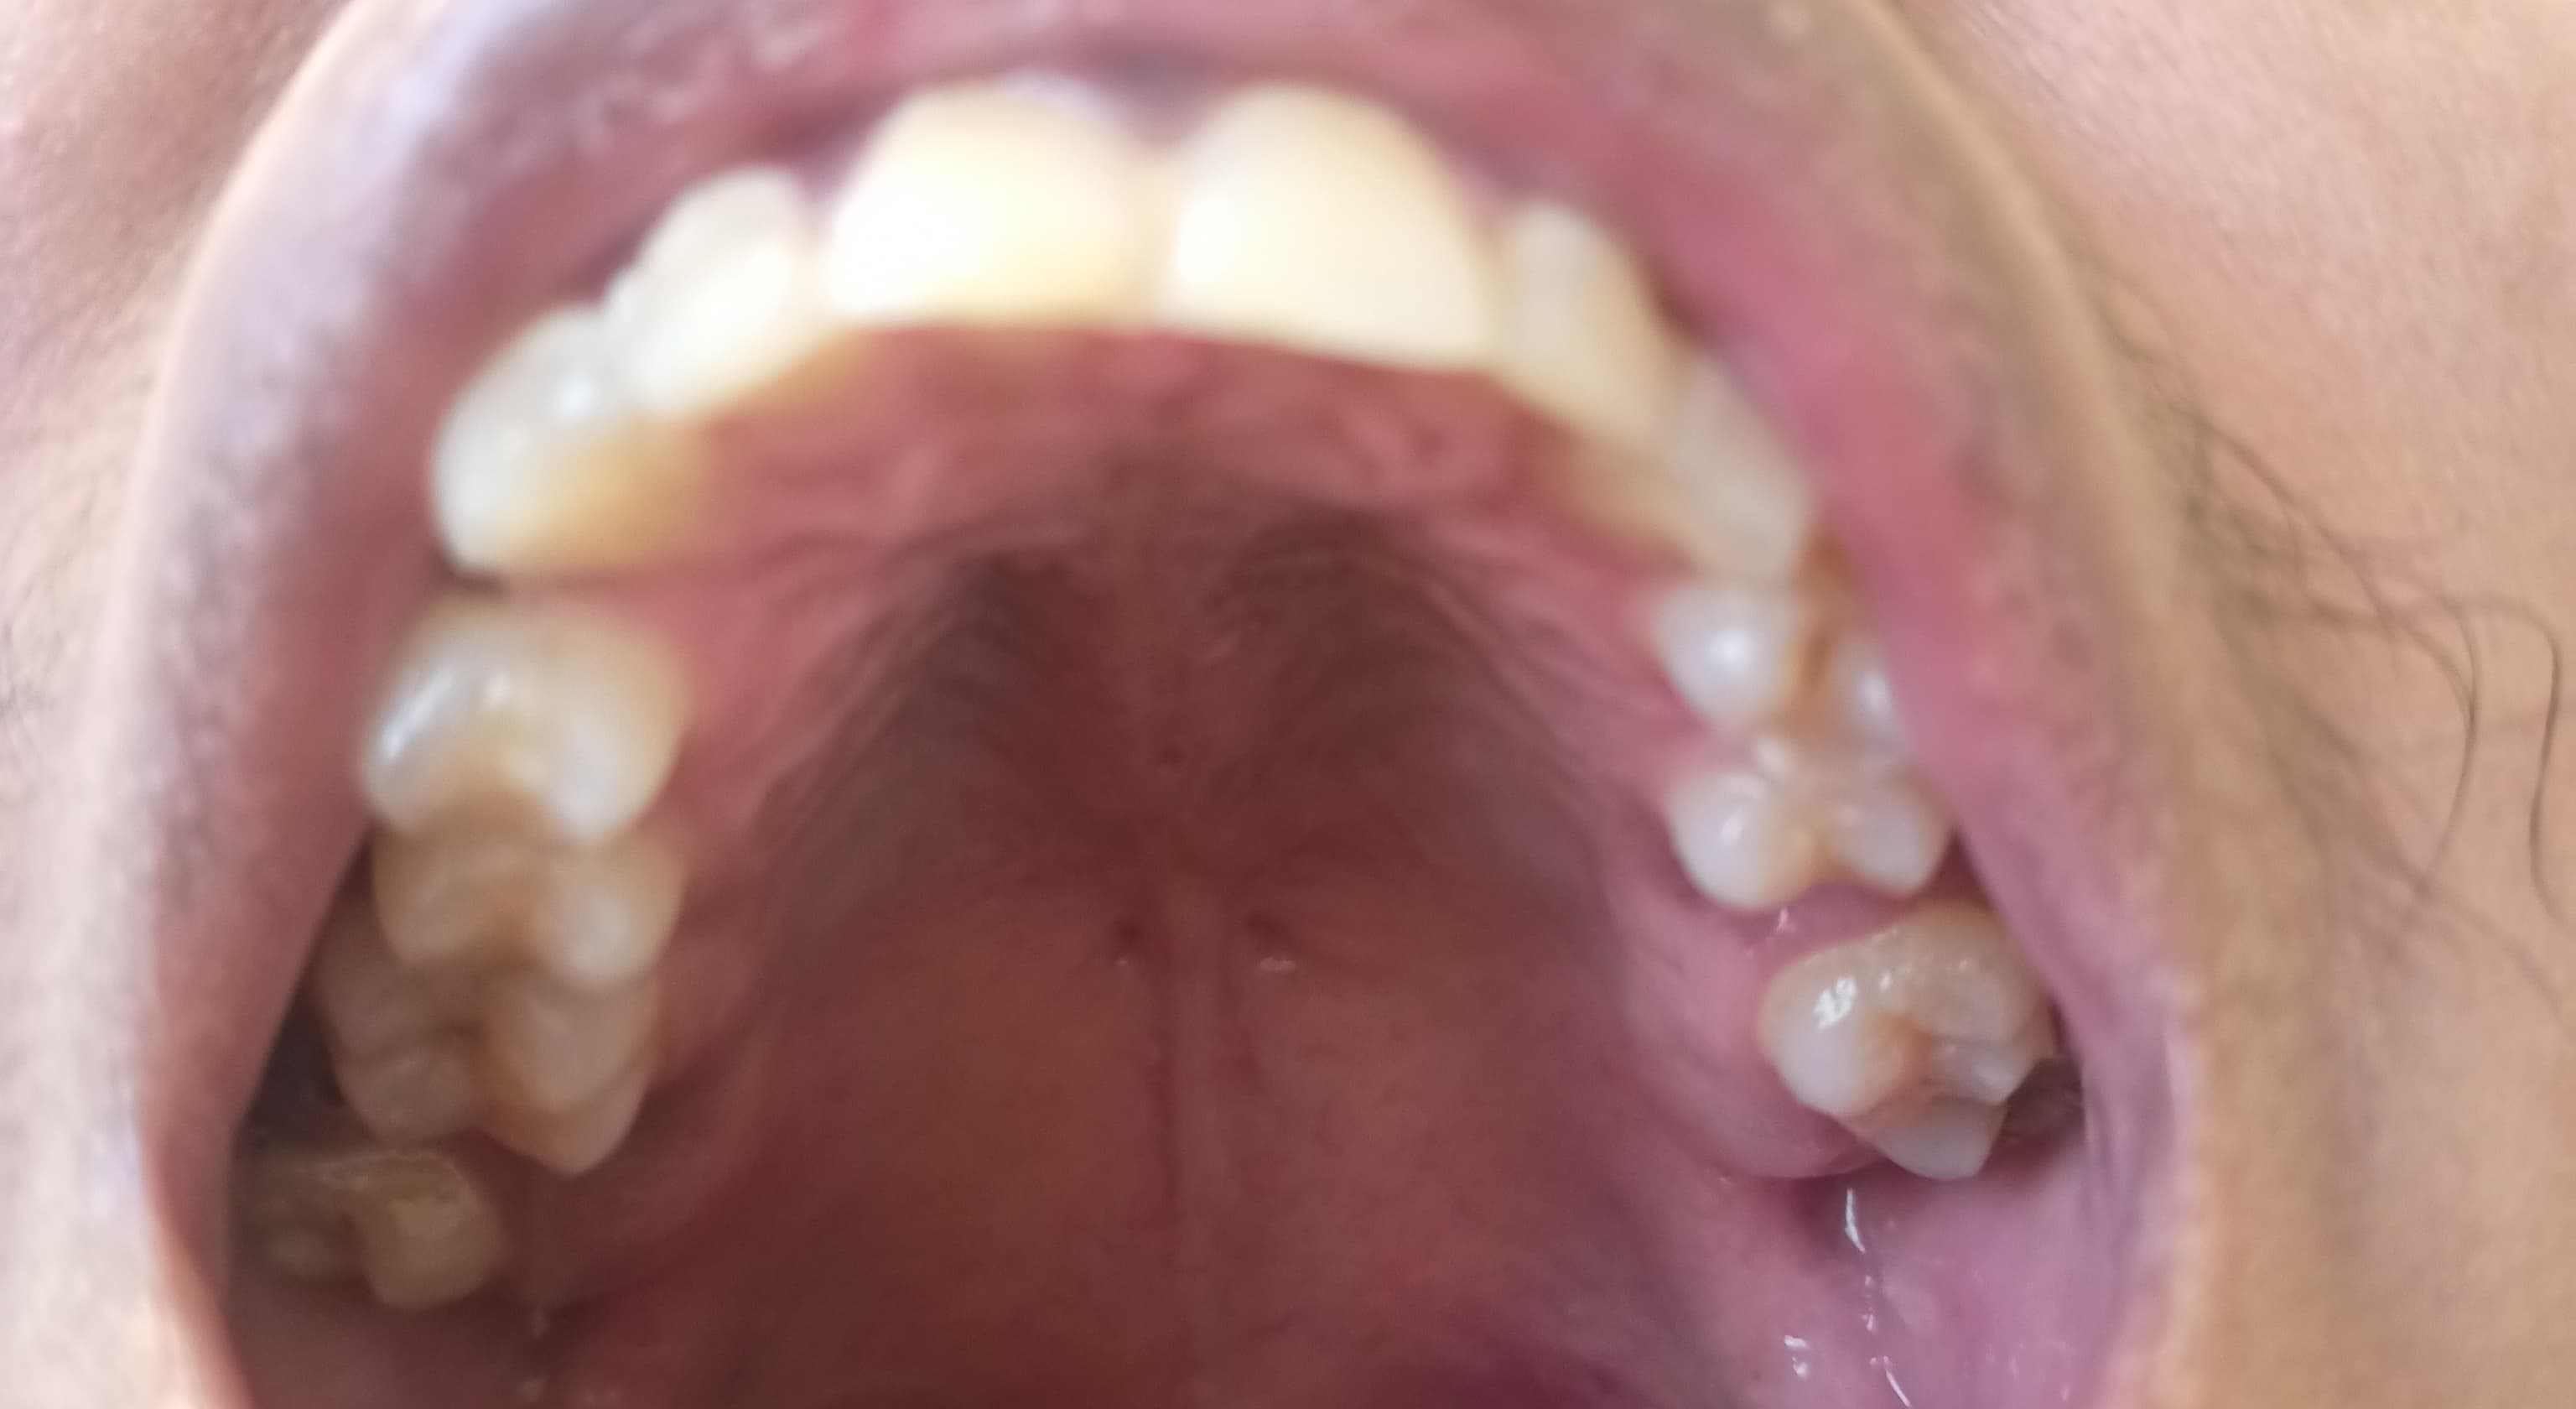


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted class for /content/drive/MyDrive/test/gigi3.jpeg: Gigi Berlubang
Class probability: 0.98


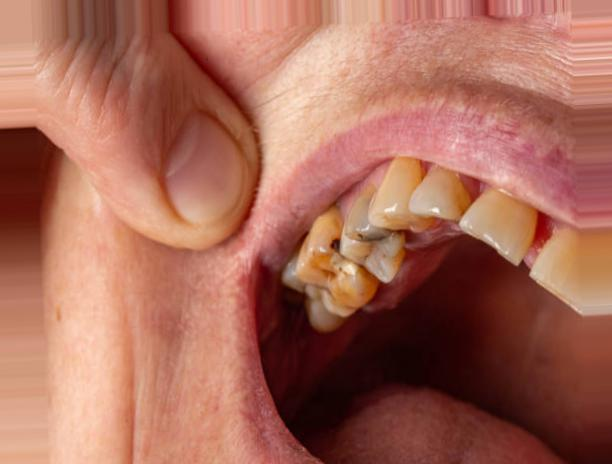


Total prediction time: 11.8916 seconds
Average time per image: 2.3783 seconds


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from IPython.display import Image, display

# Predict on test data
predictions = []
for image_path in test_image_paths:
    img = preprocess_image(image_path)
    pred = model.predict(img)
    predictions.append(pred)

    class_probabilities = pred[0]
    class_index = np.argmax(class_probabilities)
    class_name = ['Bengkak Gusi', 'Bukan Gambar Gigi', 'Gigi Berlubang', 'Gigi Sehat', 'Plak Gigi'][class_index]
    print(f'Predicted class for {image_path}: {class_name}')
    print(f'Class probability: {class_probabilities[class_index]:.2f}')

    image_data = Image(filename=image_path, width=300)
    display(image_data)
    print()  # Garis kosong untuk memisahkan output setiap gambar

end_time = time.time()
total_time = end_time - start_time
average_time_per_image = total_time / len(test_image_paths)

print(f"Total prediction time: {total_time:.4f} seconds")
print(f"Average time per image: {average_time_per_image:.4f} seconds")